# Dask through Jupyter Notebooks

This notebook will guide you through using Dask to analyze NanoAOD root files using a Slurm Cluster on SubMIT. This notebook utilizes a conda environment and then exports that environment in the slurm jobs. Follow the README for instructions on the conda environment. 

In [1]:
import os
import sys
import json
import time
import random
import numpy as np
from coffea import hist, processor

from dask_jobqueue import SLURMCluster
from distributed import Client
from dask.distributed import performance_report

/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


We set up a coffea ABC Processor to analyze the ROOT files. Here we grab the Muon and Electron collection and add some simple selections using awkward.

In [2]:
import awkward as ak
import vector
vector.register_awkward()

class Simple_Process(processor.ProcessorABC):
    def __init__(self, isMC: int, era: int, sample: str) -> None:
        self.gensumweight = 1.0
        self.era = era
        self.isMC = isMC
        self.sample = sample

        #Set up for the histograms
        self._accumulator = processor.dict_accumulator({
            "N_Muons": hist.Hist(
                "Events",
                hist.Bin("NMuons", "Num Muons", 10, 0, 10)
            ),   
            "N_Electrons": hist.Hist(
                "Events",
                hist.Bin("NElectrons", "Num Electrons", 10, 0, 10)
            ), 
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        dataset = events.metadata['dataset']
        Muons = ak.zip({
              "pt": events.Muon.pt,
              "eta": events.Muon.eta,
              "phi": events.Muon.phi,
              "mass": events.Muon.mass
        }, with_name="Momentum4D") 
        cut = (events.Muon.pt > 10) & \
            (abs(events.Muon.eta) <= 2.4) & \
            (events.Muon.mediumId == 1) 
        Muons = Muons[cut]
        
        output["N_Muons"].fill(
            NMuons = ak.num(Muons),
        ) 
        
        Electrons = ak.zip({
               "pt": events.Electron.pt,
               "eta": events.Electron.eta,
               "phi": events.Electron.phi,
               "mass": events.Electron.mass
        }, with_name="Momentum4D") 
        cut_ele = (events.Electron.pt > 10) & \
            (abs(events.Electron.eta) <= 2.4) & \
            (events.Electron.mvaFall17V2Iso_WP90 == 1) 
        Electrons = Electrons[cut_ele]
        
        output["N_Electrons"].fill(
            NElectrons = ak.num(Electrons),
        ) 
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
def check_port(port):
    import socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    try:
        sock.bind(("0.0.0.0", port))
        available = True
    except:
        available = False
    sock.close()
    return available

The following section defines additional parts of the slurm Dask job. Here we source the bashrc to prepare Conda. We also pass in the x509 proxy. In order to share the proxy across the SubMIT machines you should move your proxy to your HOME directory.

In [4]:
slurm_env = [
     'export XRD_RUNFORKHANDLER=1',
     'export XRD_STREAMTIMEOUT=10',
     f'source {os.environ["HOME"]}/.bashrc',
     f'conda activate dask',
     f'export X509_USER_PROXY={os.environ["HOME"]}/x509up_u206148'
]

extra_args=[
     "--output=dask_job_output_%j.out",
     "--error=dask_job_output_%j.err",
     "--partition=submit",
     "--clusters=submit",
]

In [5]:
n_port       = 6820
w_port       = 9765
cores        = 1
processes    = 1
memory       = "5 GB"
chunksize    = 15000
maxchunks    = None

The following sets up the processor and json file. If you want to change files you can simply modify the json file

In [6]:
#Set up the processor
processor_instance = Simple_Process(isMC=1, era='2018', sample='test')

# load dataset
with open("Rucio_JSON_Maker/sample.json") as f:
    sample_dict = json.load(f)
for key in sample_dict.keys():
    sample_dict[key] = sample_dict[key][:]

The next section forms the Slurm Cluster. You can set up various parameters of the cluster here.

In [7]:
if not check_port(n_port):
    raise RuntimeError("Port '{}' is occupied on this node. Try another one.".format(n_port))

import socket
cluster = SLURMCluster(
        queue='all',
        project="SUEP_Slurm",
        cores=cores,
        processes=processes,
        memory=memory,
        #retries=10,
        walltime='00:30:00',
        scheduler_options={
              'port': n_port,
              'dashboard_address': 8000,
              'host': socket.gethostname()
        },
        job_extra=extra_args,
        env_extra=slurm_env,
)

/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8000 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 8708 instead
  warnings.warn(
Clear task state
  Scheduler at:     tcp://18.12.2.18:6820
  dashboard at:           18.12.2.18:8708


In [8]:
cluster.adapt(minimum=1, maximum=250)
client = Client(cluster)
print(client)

Receive client connection: Client-b4347dc5-849d-11ec-9d56-000af7bd3c78


<Client: 'tcp://18.12.2.18:6820' processes=0 threads=0, memory=0 B>


# Running the processor
Now we will run the code with a performance report. This will analyze all of the input ROOT files and will store the histograms in output. Then we can analyze the output and make plots.

In [9]:
with performance_report(filename="dask-report.html"):
    output = processor.run_uproot_job(sample_dict,
             treename='Events',
             processor_instance=processor_instance,
             executor=processor.dask_executor,
             executor_args={
                           'client': client,
                           #'skipbadfiles': skipbadfiles,
                           'schema': processor.NanoAODSchema,
                           'xrootdtimeout': 10,
                           'retries': 3,
                           },
             chunksize=chunksize,
             maxchunks=maxchunks)

Run out-of-band function 'lambda'
Register worker <WorkerState 'tcp://18.12.2.18:16403', name: SLURMCluster-0, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:16403


[                                        ] | 1% Completed |  3.2s

Register worker <WorkerState 'tcp://18.12.2.18:15678', name: SLURMCluster-3, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:15678
Register worker <WorkerState 'tcp://18.12.2.18:2631', name: SLURMCluster-7, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:2631
Register worker <WorkerState 'tcp://18.12.2.18:16224', name: SLURMCluster-5, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:16224


[#####                                   ] | 13% Completed |  9.2s

Register worker <WorkerState 'tcp://18.12.2.6:46770', name: SLURMCluster-38, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.6:46770
Register worker <WorkerState 'tcp://18.12.2.6:37854', name: SLURMCluster-17, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.6:37854
Register worker <WorkerState 'tcp://18.12.2.6:44326', name: SLURMCluster-20, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.6:44326
Register worker <WorkerState 'tcp://18.12.2.6:37555', name: SLURMCluster-29, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.6:37555
Register worker <WorkerState 'tcp://18.12.2.6:33685', name: SLURMCluster-10, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.6:33685
Register worker <WorkerState 'tcp://18.12.2.6:45918', name: SLURMCluster-31, status: undefined, memory: 0, processing: 0

[#####                                   ] | 13% Completed |  9.3s

Register worker <WorkerState 'tcp://18.12.2.18:28693', name: SLURMCluster-9, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:28693
Register worker <WorkerState 'tcp://18.12.2.18:12726', name: SLURMCluster-4, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:12726
Register worker <WorkerState 'tcp://18.12.2.18:9889', name: SLURMCluster-2, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:9889
Register worker <WorkerState 'tcp://18.12.2.18:17382', name: SLURMCluster-6, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:17382
Register worker <WorkerState 'tcp://18.12.2.18:13593', name: SLURMCluster-8, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:13593
Register worker <WorkerState 'tcp://18.12.2.18:6504', name: SLURMCluster-1, status: undefined, memory: 0, processing:

[#####                                   ] | 13% Completed |  9.6s

Retire worker names ('SLURMCluster-15', 'SLURMCluster-19', 'SLURMCluster-16')


[#####                                   ] | 13% Completed |  9.8s

Register worker <WorkerState 'tcp://18.12.2.2:36167', name: SLURMCluster-41, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:36167
Register worker <WorkerState 'tcp://18.12.2.2:44257', name: SLURMCluster-45, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:44257
Register worker <WorkerState 'tcp://18.12.2.2:35343', name: SLURMCluster-23, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:35343


[######                                  ] | 15% Completed | 10.4s

Register worker <WorkerState 'tcp://18.12.2.2:34865', name: SLURMCluster-33, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:34865


[######                                  ] | 16% Completed | 10.5s

Register worker <WorkerState 'tcp://18.12.2.2:45064', name: SLURMCluster-48, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:45064
Register worker <WorkerState 'tcp://18.12.2.2:33538', name: SLURMCluster-35, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:33538


[######                                  ] | 17% Completed | 10.6s

Retire worker names ('SLURMCluster-40', 'SLURMCluster-21', 'SLURMCluster-30', 'SLURMCluster-13', 'SLURMCluster-39', 'SLURMCluster-24', 'SLURMCluster-26', 'SLURMCluster-36', 'SLURMCluster-47')


[######                                  ] | 17% Completed | 11.0s

Register worker <WorkerState 'tcp://18.12.2.2:38321', name: SLURMCluster-44, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:38321
Register worker <WorkerState 'tcp://18.12.2.2:42794', name: SLURMCluster-25, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.2:42794


[#########                               ] | 24% Completed | 11.5s

Register worker <WorkerState 'tcp://18.12.2.5:19908', name: SLURMCluster-28, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.5:19908
Register worker <WorkerState 'tcp://18.12.2.5:29569', name: SLURMCluster-34, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.5:29569
Register worker <WorkerState 'tcp://18.12.2.5:31040', name: SLURMCluster-12, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.5:31040
Register worker <WorkerState 'tcp://18.12.2.5:8145', name: SLURMCluster-18, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.5:8145
Retire worker names ('SLURMCluster-46', 'SLURMCluster-28', 'SLURMCluster-37')
Retire workers {<WorkerState 'tcp://18.12.2.5:19908', name: SLURMCluster-28, status: running, memory: 0, processing: 0>}
Closing worker tcp://18.12.2.5:19908
Remove worker <WorkerState 'tcp://18.12.2.5:19908', name: SLUR

[##############                          ] | 36% Completed | 12.6s

Retire worker names ('SLURMCluster-43', 'SLURMCluster-32', 'SLURMCluster-22')


[###############################         ] | 79% Completed | 15.5s

Retire worker names ('SLURMCluster-3',)
Retire workers {<WorkerState 'tcp://18.12.2.18:15678', name: SLURMCluster-3, status: running, memory: 3, processing: 0>}
Moving 3 keys to other workers


[####################################    ] | 91% Completed | 16.3s


Traceback (most recent call last):
  File "/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/distributed/utils.py", line 681, in log_errors
    yield
  File "/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/distributed/scheduler.py", line 6839, in retire_workers
    await self.replicate(
  File "/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/distributed/scheduler.py", line 6590, in replicate
    assert count > 0
AssertionError
Exception while handling op retire_workers
Traceback (most recent call last):
  File "/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/distributed/core.py", line 521, in handle_comm
    result = await result
  File "/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/distributed/scheduler.py", line 6839, in retire_workers
    await self.replicate(
  File "/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/distributed/scheduler.py", line 6590, in re

[####################################### ] | 98% Completed | 16.6s

Retire worker names ('SLURMCluster-10', 'SLURMCluster-2', 'SLURMCluster-20', 'SLURMCluster-38')
Retire workers {<WorkerState 'tcp://18.12.2.6:33685', name: SLURMCluster-10, status: running, memory: 0, processing: 0>, <WorkerState 'tcp://18.12.2.6:44326', name: SLURMCluster-20, status: running, memory: 0, processing: 0>, <WorkerState 'tcp://18.12.2.18:9889', name: SLURMCluster-2, status: running, memory: 0, processing: 0>, <WorkerState 'tcp://18.12.2.6:46770', name: SLURMCluster-38, status: running, memory: 0, processing: 0>}
Closing worker tcp://18.12.2.6:33685
Remove worker <WorkerState 'tcp://18.12.2.6:33685', name: SLURMCluster-10, status: running, memory: 0, processing: 0>
Closing worker tcp://18.12.2.6:44326
Remove worker <WorkerState 'tcp://18.12.2.6:44326', name: SLURMCluster-20, status: running, memory: 0, processing: 0>
Closing worker tcp://18.12.2.18:9889
Remove worker <WorkerState 'tcp://18.12.2.18:9889', name: SLURMCluster-2, status: running, memory: 0, processing: 0>
Closi

[###                                     ] | 8% Completed | 27.3s8s

Register worker <WorkerState 'tcp://18.12.2.6:37090', name: SLURMCluster-66, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.6:37090
Register worker <WorkerState 'tcp://18.12.2.6:46199', name: SLURMCluster-85, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.6:46199
Register worker <WorkerState 'tcp://18.12.2.6:34877', name: SLURMCluster-83, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.6:34877
Register worker <WorkerState 'tcp://18.12.2.7:36888', name: SLURMCluster-55, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.7:36888
Register worker <WorkerState 'tcp://18.12.2.7:38781', name: SLURMCluster-87, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.7:38781
Register worker <WorkerState 'tcp://18.12.2.7:39862', name: SLURMCluster-84, status: undefined, memory: 0, processing: 0

[########                                ] | 20% Completed | 27.4s

Register worker <WorkerState 'tcp://18.12.2.9:33084', name: SLURMCluster-78, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.9:33084
Register worker <WorkerState 'tcp://18.12.2.9:36244', name: SLURMCluster-111, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.9:36244
Register worker <WorkerState 'tcp://18.12.2.9:44054', name: SLURMCluster-113, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.9:44054
Register worker <WorkerState 'tcp://18.12.2.9:37598', name: SLURMCluster-82, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.9:37598
Register worker <WorkerState 'tcp://18.12.2.9:43319', name: SLURMCluster-128, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.9:43319
Register worker <WorkerState 'tcp://18.12.2.9:36564', name: SLURMCluster-122, status: undefined, memory: 0, processin

[###########################             ] | 67% Completed | 53.4s

Retire worker names ('SLURMCluster-50', 'SLURMCluster-194', 'SLURMCluster-145', 'SLURMCluster-266', 'SLURMCluster-152', 'SLURMCluster-245', 'SLURMCluster-217', 'SLURMCluster-246', 'SLURMCluster-90', 'SLURMCluster-120', 'SLURMCluster-60', 'SLURMCluster-239')


[###########################             ] | 69% Completed | 54.4s

Retire worker names ('SLURMCluster-189', 'SLURMCluster-143', 'SLURMCluster-171', 'SLURMCluster-268', 'SLURMCluster-244', 'SLURMCluster-146', 'SLURMCluster-115', 'SLURMCluster-97', 'SLURMCluster-158', 'SLURMCluster-269', 'SLURMCluster-104', 'SLURMCluster-53', 'SLURMCluster-149', 'SLURMCluster-180', 'SLURMCluster-159', 'SLURMCluster-137', 'SLURMCluster-178', 'SLURMCluster-259', 'SLURMCluster-170', 'SLURMCluster-223', 'SLURMCluster-125', 'SLURMCluster-167', 'SLURMCluster-57', 'SLURMCluster-258', 'SLURMCluster-267', 'SLURMCluster-185', 'SLURMCluster-103', 'SLURMCluster-207', 'SLURMCluster-209', 'SLURMCluster-168', 'SLURMCluster-80', 'SLURMCluster-220', 'SLURMCluster-255')


[#####################################   ] | 93% Completed |  1min  7.4s

Retire worker names ('SLURMCluster-237', 'SLURMCluster-210', 'SLURMCluster-165', 'SLURMCluster-140', 'SLURMCluster-261', 'SLURMCluster-141', 'SLURMCluster-96', 'SLURMCluster-62', 'SLURMCluster-92', 'SLURMCluster-200', 'SLURMCluster-164', 'SLURMCluster-253', 'SLURMCluster-133', 'SLURMCluster-247', 'SLURMCluster-206', 'SLURMCluster-72', 'SLURMCluster-77', 'SLURMCluster-197', 'SLURMCluster-196', 'SLURMCluster-225', 'SLURMCluster-76', 'SLURMCluster-262', 'SLURMCluster-235', 'SLURMCluster-73', 'SLURMCluster-88', 'SLURMCluster-251', 'SLURMCluster-176', 'SLURMCluster-135', 'SLURMCluster-234', 'SLURMCluster-184', 'SLURMCluster-271')


[####################################### ] | 98% Completed |  1min  9.4s

Retire worker names ('SLURMCluster-83', 'SLURMCluster-66', 'SLURMCluster-31', 'SLURMCluster-27', 'SLURMCluster-101', 'SLURMCluster-130', 'SLURMCluster-55', 'SLURMCluster-85', 'SLURMCluster-64', 'SLURMCluster-187', 'SLURMCluster-75', 'SLURMCluster-81', 'SLURMCluster-136', 'SLURMCluster-205', 'SLURMCluster-58', 'SLURMCluster-233', 'SLURMCluster-166', 'SLURMCluster-138', 'SLURMCluster-199', 'SLURMCluster-211', 'SLURMCluster-202', 'SLURMCluster-218', 'SLURMCluster-98', 'SLURMCluster-188', 'SLURMCluster-232', 'SLURMCluster-238', 'SLURMCluster-252', 'SLURMCluster-172', 'SLURMCluster-256', 'SLURMCluster-84', 'SLURMCluster-241', 'SLURMCluster-270', 'SLURMCluster-163', 'SLURMCluster-109', 'SLURMCluster-100', 'SLURMCluster-126', 'SLURMCluster-198', 'SLURMCluster-249', 'SLURMCluster-142', 'SLURMCluster-71', 'SLURMCluster-117', 'SLURMCluster-144', 'SLURMCluster-56', 'SLURMCluster-192', 'SLURMCluster-79', 'SLURMCluster-118', 'SLURMCluster-179', 'SLURMCluster-157', 'SLURMCluster-177', 'SLURMCluster-

[####################################### ] | 98% Completed |  1min  9.5s

Closing worker tcp://18.12.2.9:37598
Remove worker <WorkerState 'tcp://18.12.2.9:37598', name: SLURMCluster-82, status: running, memory: 4, processing: 0>
Closing worker tcp://18.12.2.8:32965
Remove worker <WorkerState 'tcp://18.12.2.8:32965', name: SLURMCluster-119, status: running, memory: 2, processing: 0>
Closing worker tcp://18.12.2.9:38296
Remove worker <WorkerState 'tcp://18.12.2.9:38296', name: SLURMCluster-101, status: running, memory: 2, processing: 0>
Closing worker tcp://18.12.2.7:35751
Remove worker <WorkerState 'tcp://18.12.2.7:35751', name: SLURMCluster-64, status: running, memory: 2, processing: 0>
Closing worker tcp://18.12.2.6:45918
Remove worker <WorkerState 'tcp://18.12.2.6:45918', name: SLURMCluster-31, status: running, memory: 5, processing: 0>
Closing worker tcp://18.12.2.7:36888
Remove worker <WorkerState 'tcp://18.12.2.7:36888', name: SLURMCluster-55, status: running, memory: 3, processing: 0>
Closing worker tcp://18.12.2.5:6931
Remove worker <WorkerState 'tcp:

[####################################### ] | 99% Completed |  1min 29.4s

Retire worker names ('SLURMCluster-48', 'SLURMCluster-114', 'SLURMCluster-18', 'SLURMCluster-113', 'SLURMCluster-129', 'SLURMCluster-122', 'SLURMCluster-102', 'SLURMCluster-8', 'SLURMCluster-78', 'SLURMCluster-111', 'SLURMCluster-44')
Retire workers {<WorkerState 'tcp://18.12.2.18:13593', name: SLURMCluster-8, status: running, memory: 3, processing: 0>, <WorkerState 'tcp://18.12.2.5:19409', name: SLURMCluster-102, status: running, memory: 1, processing: 0>, <WorkerState 'tcp://18.12.2.5:8145', name: SLURMCluster-18, status: running, memory: 2, processing: 0>, <WorkerState 'tcp://18.12.2.2:38321', name: SLURMCluster-44, status: running, memory: 1, processing: 0>, <WorkerState 'tcp://18.12.2.9:33084', name: SLURMCluster-78, status: running, memory: 2, processing: 0>, <WorkerState 'tcp://18.12.2.8:10811', name: SLURMCluster-129, status: running, memory: 1, processing: 0>, <WorkerState 'tcp://18.12.2.9:36244', name: SLURMCluster-111, status: running, memory: 2, processing: 0>, <WorkerState

[####################################### ] | 99% Completed |  1min 30.4s

Retire worker names ('SLURMCluster-52', 'SLURMCluster-9', 'SLURMCluster-105', 'SLURMCluster-65', 'SLURMCluster-127', 'SLURMCluster-0', 'SLURMCluster-3', 'SLURMCluster-14', 'SLURMCluster-99', 'SLURMCluster-74', 'SLURMCluster-41', 'SLURMCluster-124', 'SLURMCluster-54', 'SLURMCluster-93', 'SLURMCluster-49', 'SLURMCluster-107', 'SLURMCluster-106', 'SLURMCluster-17', 'SLURMCluster-6', 'SLURMCluster-33', 'SLURMCluster-67', 'SLURMCluster-89', 'SLURMCluster-7', 'SLURMCluster-1', 'SLURMCluster-128', 'SLURMCluster-11', 'SLURMCluster-42', 'SLURMCluster-5', 'SLURMCluster-45', 'SLURMCluster-34', 'SLURMCluster-12', 'SLURMCluster-29', 'SLURMCluster-70', 'SLURMCluster-94', 'SLURMCluster-23', 'SLURMCluster-87', 'SLURMCluster-25')
Retire workers {<WorkerState 'tcp://18.12.2.8:16119', name: SLURMCluster-89, status: running, memory: 1, processing: 0>, <WorkerState 'tcp://18.12.2.5:2547', name: SLURMCluster-93, status: running, memory: 1, processing: 0>, <WorkerState 'tcp://18.12.2.18:16403', name: SLURMCl

[####################################### ] | 99% Completed |  1min 30.5s

Closing worker tcp://18.12.2.8:16119
Remove worker <WorkerState 'tcp://18.12.2.8:16119', name: SLURMCluster-89, status: running, memory: 1, processing: 0>
Closing worker tcp://18.12.2.5:2547
Remove worker <WorkerState 'tcp://18.12.2.5:2547', name: SLURMCluster-93, status: running, memory: 1, processing: 0>
Closing worker tcp://18.12.2.18:16403
Remove worker <WorkerState 'tcp://18.12.2.18:16403', name: SLURMCluster-0, status: running, memory: 4, processing: 0>
Closing worker tcp://18.12.2.9:43319
Remove worker <WorkerState 'tcp://18.12.2.9:43319', name: SLURMCluster-128, status: running, memory: 4, processing: 0>
Closing worker tcp://18.12.2.5:25522
Remove worker <WorkerState 'tcp://18.12.2.5:25522', name: SLURMCluster-52, status: running, memory: 2, processing: 0>
Closing worker tcp://18.12.2.5:16788
Remove worker <WorkerState 'tcp://18.12.2.5:16788', name: SLURMCluster-94, status: running, memory: 3, processing: 0>
Closing worker tcp://18.12.2.7:33165
Remove worker <WorkerState 'tcp:/

[####################################### ] | 99% Completed |  1min 32.4s

Retire worker names ('SLURMCluster-35', 'SLURMCluster-134')
Retire workers {<WorkerState 'tcp://18.12.2.2:33538', name: SLURMCluster-35, status: running, memory: 10, processing: 0>, <WorkerState 'tcp://18.12.2.8:21132', name: SLURMCluster-134, status: running, memory: 13, processing: 0>}
Moving 21 keys to other workers
Closing worker tcp://18.12.2.2:33538
Remove worker <WorkerState 'tcp://18.12.2.2:33538', name: SLURMCluster-35, status: running, memory: 10, processing: 0>
Closing worker tcp://18.12.2.8:21132
Remove worker <WorkerState 'tcp://18.12.2.8:21132', name: SLURMCluster-134, status: running, memory: 13, processing: 0>


[####################################### ] | 99% Completed |  1min 34.4s

Retire worker names ('SLURMCluster-4',)
Retire workers {<WorkerState 'tcp://18.12.2.18:12726', name: SLURMCluster-4, status: running, memory: 21, processing: 0>}
Moving 20 keys to other workers
Closing worker tcp://18.12.2.18:12726
Remove worker <WorkerState 'tcp://18.12.2.18:12726', name: SLURMCluster-4, status: running, memory: 21, processing: 0>


In [10]:
output['N_Muons']

<Hist (NMuons) instance at 0x7f66c4e3aac0>

/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


<AxesSubplot:xlabel='Num Muons', ylabel='Events'>

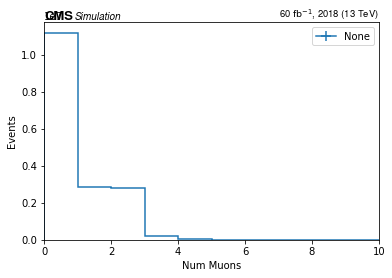

In [13]:
import mplhep as hep
#import hist
from coffea import hist

# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False, lumi=60, year=2018)

import matplotlib.pyplot as plt
hist.plot1d(output['N_Muons'])

/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/submit/freerc/miniforge3/envs/dask/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


<AxesSubplot:xlabel='Num Electrons', ylabel='Events'>

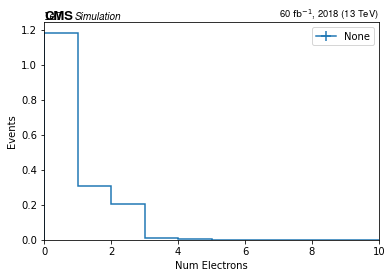

Remove worker <WorkerState 'tcp://18.12.2.9:40586', name: SLURMCluster-123, status: running, memory: 0, processing: 0>
Lost all workers
Register worker <WorkerState 'tcp://18.12.2.18:23426', name: SLURMCluster-123, status: undefined, memory: 0, processing: 0>
Starting worker compute stream, tcp://18.12.2.18:23426


In [14]:
hep.cms.label(data=False, lumi=60, year=2018)
hist.plot1d(output['N_Electrons'])